# Team Members:

- Brian Gaither
- Sabrina Purvis
- Andrew Larsen
- Aurian Ghaemmaghami

# Overview

This notebook is organized in sections by Model.  There are two tasks. Task 1 is regression and Task 2 is Classification.  There are three models per task.

For each Model in each Task, we will walk the reader through the various phases of this deliverable: Data Preparation,  Modeling and Evaluation

<a id="top"></a>
## Contents
* **<a href="#task1">Task 1 - Regression</a>**
    - <a href="#task1Model1">Model 1 - KNN</a>
    - <a href="#task1Model2">Model 2 - Logistic Regression</a>
    - <a href="#task1Model3">Model 3 - Random Forest Regression</a>
    - <a href="#task1Compare">Task 1 - Comparing the Three Models</a>
    - <a href="#task1Attributes">Task 1 - Important Attributes</a>
    - <a href="#task1Deployment">Task 1 - Deployment</a>
* **<a href="#task2">Task 2 - Classification</a>**
    - <a href="#task2Model1">Model 1 - Random Forest (Approach 1)</a>
    - <a href="#task2Model2">Model 2 - Logistic Regression</a>
    - <a href="#task2Model3">Model 3 - Random Forest (Approach 2)</a>
    - <a href="#task2Compare">Task 2 - Comparing the Three Models</a>
    - <a href="#task2Attributes">Task 2 - Important Attributes</a>
    - <a href="#task2Deployment">Task 2 - Deployment</a>
* **<a href="#Exceptional">Exceptional Work</a>**


<a href="#top">Back to Top</a>
<a id="task1"></a>
# Task 1 - Regression

The regression task is aiming to predict the volume of crime on a given day, for a given time period of the day (Early Morning, Morning, Day, Afternoon, etc...) by location.

<a href="#top">Back to Top</a>
<a id="task1Model1"></a>
## Task 1 - Regression - Model 1 - KNN

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from matplotlib.dates import DayLocator, MonthLocator, DateFormatter, drange
import seaborn as sns

## Data Preparation Part 1

Here, we read in the data and parse the CMPLNT_FR_DT variable as datetime.

In [4]:
df = pd.read_csv('/home/drew/School/Semester4/ML1/NewYorkCityCrimes2015/Data/Lab2_Daily_Crime_Volume_Data/Training_and_Test_Set.csv',
                parse_dates = ['CMPLNT_FR_DT'])

As you can see below, there are many variables that are non-numeric. KNN accepts only numeric variables, so we must do some pre-processing in order to use these variables in our model.

In [4]:
df.head(10)

CMPLNT_FR_DT     Daytime   Day_Name      Month   Day    Year  Season  \
0   2014-11-26     Morning  Wednesday   November  26.0  2014.0    Fall   
1   2014-12-01  Late Night     Monday   December   1.0  2014.0  Winter   
2   2015-11-10     Morning    Tuesday   November  10.0  2015.0    Fall   
3   2014-02-04     Morning    Tuesday   February   4.0  2014.0  Winter   
4   2015-08-25  Late Night    Tuesday     August  25.0  2015.0  Summer   
5   2014-09-03     Morning  Wednesday  September   3.0  2014.0    Fall   
6   2015-09-17     Morning   Thursday  September  17.0  2015.0    Fall   
7   2015-01-29     Morning   Thursday    January  29.0  2015.0  Winter   
8   2015-03-12     Evening   Thursday      March  12.0  2015.0  Spring   
9   2014-06-23  Late Night     Monday       June  23.0  2014.0  Summer   

   GeoCell        BORO_NM  PRCP  ...  TMIN  TMAX  Population PC_INCOME  \
0     66.0         QUEENS  1.24  ...    34    51   2,250,002     40997   
1     60.0         QUEENS  0.09  ...    42    65   2,250,002     40997   
2     15.0       BROOKLYN  0.26  ...    51    57   2,552,911     43915   
3     48.0         QUEENS  0.00  ...    22    35   2,250,002     40997   
4     35.0       BROOKLYN  0.00  ...    73    90   2,552,911     43915   
5     23.0  STATEN ISLAND  0.00  ...    72    86     468,730     48123   
6     49.0         QUEENS  0.00  ...    68    89   2,250,002     44031   
7     35.0       BROOKLYN  0.02  ...    19    36   2,552,911     43915   
8     67.0         QUEENS  0.00  ...    36    47   2,250,002     44031   
9     48.0         QUEENS  0.00  ...    65    81   2,250,002     40997   

   Hm_Sls_Price_Range Holiday               Event is_Holiday  is_Event  \
0              Medium     NaN                 NaN          0         0   
1              Medium     NaN                 NaN          0         0   
2                High     NaN                 NaN          0         0   
3              Medium     NaN                 NaN          0         0   
4                High     NaN                 NaN          0         0   
5                 Low     NaN      US Open Tennis          0         1   
6              Medium     NaN  New York Boat Show          0         1   
7                High     NaN                 NaN          0         0   
8              Medium     NaN                 NaN          0         0   
9              Medium     NaN                 NaN          0         0   

   count_cmplnt  
0             1  
1             1  
2             2  
3             3  
4             1  
5             1  
6             7  
7             5  
8             1  
9             3  

[10 rows x 21 columns]

Our Day_Name variable was built off of the CMPLNT_FR_DT variable. In order to turn that variable into a numeric variable, we simply use the dt.dayofweek function from pandas in order to change "Monday" to 0, "Tuesday" to 1 etc. 

In [6]:
df['DayOfWeek'] = df['CMPLNT_FR_DT'].dt.dayofweek

Similar to the dayofweek function, dt.month turns January into 1, February into 2, etc. We use this function to change our Month variable into a numeric variable. 

In [7]:
df['Month_No'] = df['CMPLNT_FR_DT'].dt.month
df_Crime = df

As you can see in the plot below, there does seem to be a temporal dependence of number of crimes. Crimes seem to peak in the summer and drop in the winter. We encode this temporal dependence as numeric variables identifying the month, the year and the day. 

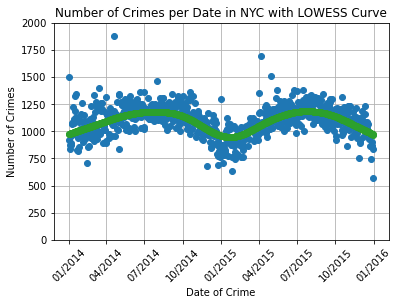

In [7]:
df_Crime['CMPLNT_FR_DT'] = pd.to_datetime(df_Crime['CMPLNT_FR_DT'], format = '%m/%d/%Y')
crimeByDate = df_Crime.groupby('CMPLNT_FR_DT')['count_cmplnt'].sum().reset_index()
fig, ax = plt.subplots()
plt.xlabel('Date of Crime')
plt.ylabel('Number of Crimes')
plt.grid(True)
plt.ylim(-5, 2000)
plt.title('Number of Crimes per Date in NYC with LOWESS Curve')
plt.plot_date(crimeByDate['CMPLNT_FR_DT'], crimeByDate['count_cmplnt'])
plt.plot_date(crimeByDate['CMPLNT_FR_DT'],lowess(crimeByDate['count_cmplnt'],crimeByDate['CMPLNT_FR_DT'], frac = .25))
ax.xaxis.set_tick_params(rotation=45, labelsize=10)
ax.xaxis.set_major_formatter(DateFormatter('%m/%Y'))
plt.show()

As you can see in the plot below, there does seem to be a dependence of number of crimes on the burough. Borough is categorical, but we have 3 numeric variables that correspond to the borough: Population, Hm_Sls_Price_Range and PC_INCOME, so we only need one of these variables in our final model. The population variable was chosen due to the ease of turning this variable into numeric, though we could have used any other variable listed above. 

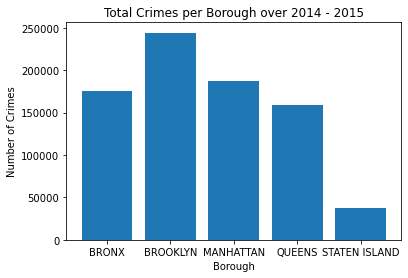

In [8]:
borodf = df_Crime.groupby('BORO_NM')['count_cmplnt'].sum().reset_index()
fig, ax = plt.subplots()
plt.xlabel('Borough')
plt.ylabel('Number of Crimes')
plt.title('Total Crimes per Borough over 2014 - 2015')
plt.bar(borodf['BORO_NM'], borodf['count_cmplnt']);

The time of day does look to have some influence on the number of crimes as well, with evening and day time seeming to have the most crimes, although morning and night have the 4 largest count_cmplnts. 

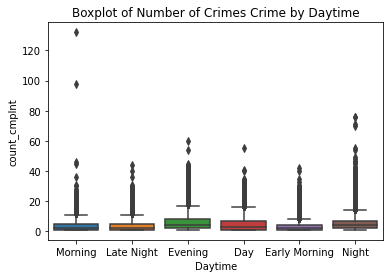

In [9]:
ax = sns.boxplot(x="Daytime", y="count_cmplnt", data=df_Crime)
ax.set_title("Boxplot of Number of Crimes Crime by Daytime");

Below is a graph of the total crimes per day of the week over 2014 - 2015. The most crimes occur on Friday, and the fewest crimes occur on Sunday. There isn't a large difference between the individual days of the week, but there may be enough difference between Friday and Sunday to have an impact on our models. 

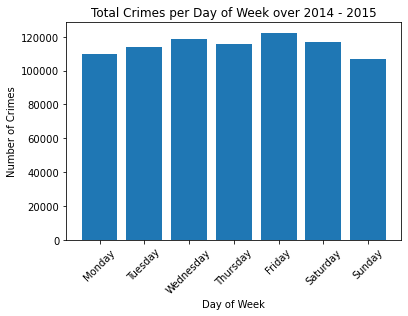

In [10]:
dowdf = df_Crime.groupby('DayOfWeek')['count_cmplnt'].sum().reset_index()
fig, ax = plt.subplots()
plt.xlabel('Day of Week')
plt.ylabel('Number of Crimes')
plt.title('Total Crimes per Day of Week over 2014 - 2015')
plt.bar(dowdf['DayOfWeek'], dowdf['count_cmplnt']);
ax.xaxis.set_tick_params(rotation=45, labelsize=10)
plt.xticks(np.arange(7),['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']);

In order to bring the latitude and longitude into the grouped analysis, we created 100 GeoCells to bin the locations of crimes. When we plot the number of crimes by location, we find a large difference between the 100 geocells. GeoCell number 87 has a two year crime count of 48,434, while many of these GeoCells have no crime at all. Crime count has a large dependence on location. A bar plot was chosen since we were interested in looking at the total number of crimes across levels of a categorical variable. 

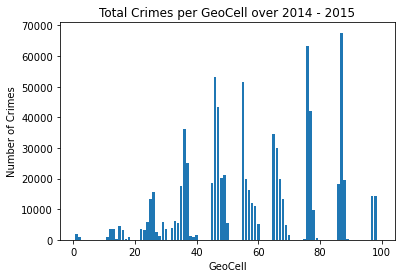

In [11]:
locdf = df_Crime.groupby('GeoCell')['count_cmplnt'].sum().reset_index()
fig, ax = plt.subplots()
plt.xlabel('GeoCell')
plt.ylabel('Number of Crimes')
plt.title('Total Crimes per GeoCell over 2014 - 2015')
plt.bar(locdf['GeoCell'], locdf['count_cmplnt']);

When we look at the number of crimes per day vs. the daily high temperature, we can see that crime seems to increase lineraly as temperature increases. This seems to confirm what we saw in the plot of crimes per month: the colder winter months have lower amounts of crime, while the warmer summer months have larger amounts of crime. 

<ipython-input-8-12e0611d08f5>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp_df = df_Crime.groupby('CMPLNT_FR_DT')['TMAX','TMIN', 'SNOW', 'PRCP'].max();


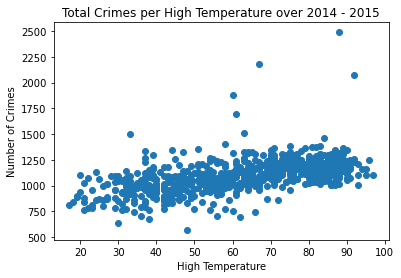

In [8]:
datedf = df_Crime.groupby('CMPLNT_FR_DT')['count_cmplnt'].sum().reset_index()
temp_df = df_Crime.groupby('CMPLNT_FR_DT')['TMAX','TMIN', 'SNOW', 'PRCP'].max();
tempdf = datedf.join(temp_df, on = 'CMPLNT_FR_DT');
fig, ax = plt.subplots()
plt.scatter(tempdf['TMAX'], tempdf['count_cmplnt']);
plt.xlabel('High Temperature')
plt.ylabel('Number of Crimes')
plt.title('Total Crimes per High Temperature over 2014 - 2015');

The daily low temperature is highly correlated with the daily high temperature, so the plot of low temperature vs. number of crimes is nearly identical to the high temperature vs. number of crimes. Both were included in the KNN model due to potential extreme fluxuations in temperature in New York City. 

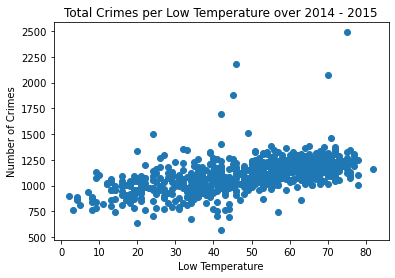

In [13]:
fig, ax = plt.subplots()
plt.scatter(tempdf['TMIN'], tempdf['count_cmplnt'])
plt.xlabel('Low Temperature')
plt.ylabel('Number of Crimes')
plt.title('Total Crimes per Low Temperature over 2014 - 2015');

Here, we look at the amount of snow vs. the crime count. It does not snow very often in New York so it is hard to tell if there is a trend with so few data points, but number of crimes does seem to have a negative linear dependence on the amount of snow that New York recieves.

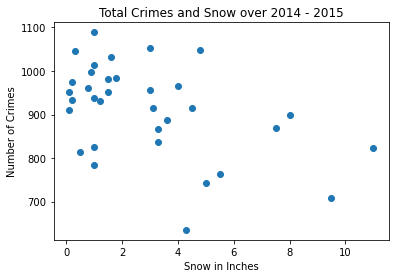

In [14]:
snowdf = tempdf[tempdf['SNOW'] > 0]
fig, ax = plt.subplots()

plt.scatter(snowdf['SNOW'], snowdf['count_cmplnt'])
plt.xlabel('Snow in Inches')
plt.ylabel('Number of Crimes')
plt.title('Total Crimes and Snow over 2014 - 2015');

Here, we look at the amount of daily rain that New York recieved vs. the number of crimes that day. Removing days where there was no rain, there may be a slight negative trend.

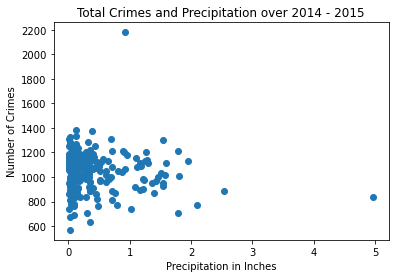

In [15]:
prcpdf = tempdf[tempdf['PRCP'] > 0]
fig, ax = plt.subplots()
plt.scatter(prcpdf['PRCP'], prcpdf['count_cmplnt'])
plt.xlabel('Precipitation in Inches')
plt.ylabel('Number of Crimes')
plt.title('Total Crimes and Precipitation over 2014 - 2015');

There isn't a lot to visually separate holidays from non-holidays as far as crime count goes, but we are going to keep it in the model as that could be due to the relatively large outliers.  

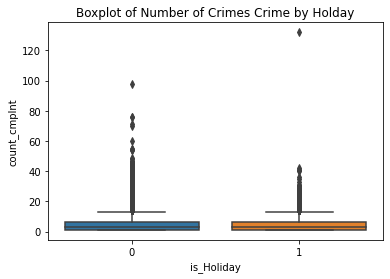

In [16]:
ax = sns.boxplot(x="is_Holiday", y="count_cmplnt", data=df_Crime)
ax.set_title("Boxplot of Number of Crimes Crime by Holday");

Similar to holiday, there isn't a lot to visually separate events from non-events as far as crime count goes, but we are going to keep it in the model as that could be due to the relatively large outliers.  

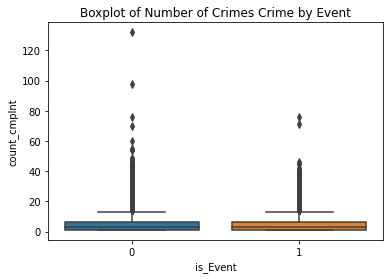

In [17]:
ax = sns.boxplot(x="is_Event", y="count_cmplnt", data=df_Crime)
ax.set_title("Boxplot of Number of Crimes Crime by Event");

Below we remove commas and turn Population into a numeric variable. 

In [18]:
df['Population'] = pd.to_numeric(df['Population'].str.replace(',','', regex = False))

Below is the list of variables still in our dataframe. There are still some non-numeric variables listed.

In [19]:
list(df)

['CMPLNT_FR_DT',
 'Daytime',
 'Day_Name',
 'Month',
 'Day',
 'Year',
 'Season',
 'GeoCell',
 'BORO_NM',
 'PRCP',
 'SNOW',
 'TMIN',
 'TMAX',
 'Population',
 'PC_INCOME',
 'Hm_Sls_Price_Range',
 'Holiday',
 'Event',
 'is_Holiday',
 'is_Event',
 'count_cmplnt',
 'DayOfWeek',
 'Month_No']

Here, we drop the variables that are non-numeric and have been represented in numeric in a different variable. The only variable that hadn't been transformed into numeric was the daytime variable, which was one-hot-encoded using the get_dummies function, which automatically one-hot-encodes then drops the categorical variables remaining in the dataframe.

In [20]:
KNNdf = df.drop(['Holiday', 'Event', 'Day_Name', 'Month', 'BORO_NM', 'PC_INCOME','Hm_Sls_Price_Range', 'Season', 'CMPLNT_FR_DT'], axis = 1)
KNNdf = pd.get_dummies(KNNdf)

As you can see below, all variables are now numeric.

In [21]:
KNNdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170650 entries, 0 to 170649
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Day                    170650 non-null  float64
 1   Year                   170650 non-null  float64
 2   GeoCell                170650 non-null  float64
 3   PRCP                   170650 non-null  float64
 4   SNOW                   170650 non-null  float64
 5   TMIN                   170650 non-null  int64  
 6   TMAX                   170650 non-null  int64  
 7   Population             170650 non-null  int64  
 8   is_Holiday             170650 non-null  int64  
 9   is_Event               170650 non-null  int64  
 10  count_cmplnt           170650 non-null  int64  
 11  DayOfWeek              170650 non-null  int64  
 12  Month_No               170650 non-null  int64  
 13  Daytime_Day            170650 non-null  uint8  
 14  Daytime_Early Morning  170650 non-nu

We did scale the variables, but in order to avoid data leakage, we scaled after creating the train/test split. This will be addressed in the Modeling and Evaluation 2 section where we address our train/test split. 

## Data Preparation Part 2

These are the variables that we will use in our KNN regression model, as well as the target variable: count_cmplnt. Here are descriptions of the variables below:  

|Variable Label|Variable Type|Data Description|  
| :-|:-|:-|  
|count_cmplnt|Numeric|	Number of crimes per day per time of day per GeoCell. Our target variable|  
|Day|Numeric|Day of the month from 1 to 31|  
|Year|Numeric|The year, either 2014 or 2015|  
|GeoCell|Numeric|The GeoCell that the crime occurred in. We split New York City into 100 GeoCells and used the latitude and longitude of the crime to determine which GeoCell the crime was located in.|  
|PRCP|Numeric|Amount of precipitation on the day the crimes occurred, in inches|  
|SNOW|Numeric|Amount of snow on the day the crimes occurred, in inches|  
|TMIN|Numeric|	The maximum temperature on the day the crimes occurred, in Farenheit|  
|TMAX|Numeric|	The minimum temperature on the day the crimes occurred, in Farenheit|  
|Population|Numeric| Population of the borough in which the GeoCell is located|  
|is_Holiday|Binary| 1 if the day in question was a holiday, 0 if not|  
|is_Event|Binary|	1 if the day in question had a major event, 0 if not|  
|DayOfWeek|Numeric|	The day of the week. 0 for Monday, 1 for Tuesday etc. |  
|Month_No|Numeric|	The month. 1 for January, 2 for February etc. |  
|Daytime_Day|Binary| 1 signifies if the count_cmplnt variable is related to crimes between 10:00am and 2:00pm, 0 if not|  
|Daytime_Early Morning|Binary|1 signifies if the count_cmplnt variable is related to crimes between 2:00am and 6:00am, 0 if not|  
|Daytime_Evening|Binary|	1 signifies if the count_cmplnt variable is related to crimes between 2:00pm and 6:00pm, 0 if not|  
|Daytime_Late Night|Binary|	1 signifies if the count_cmplnt variable is related to crimes between 10:00pm and 2:00am, 0 if not|  
|Daytime_Morning|Binary|1 signifies if the count_cmplnt variable is related to crimes between 6:00am and 10:00am, 0 if not|  
|Daytime_Night|Binary|	1 signifies if the count_cmplnt variable is related to crimes between 6:00pm and 10:00pm, 0 if not|  

## Modeling and Evaluation 1

In our analysis, we used the following metrics to determine how well our models fit the data:

|Metric|Used Where?|Metric Description|  
| :-|:-|:-|  
|Root Mean Squared Error (RMSE)|Training, Testing, Holdout|Defined as $\sum\sqrt{(predicted - actual)^2}$ This metric is in terms of the target variable, in this case number of crimes. RMSE is used to choose the best K for both weighted and non-weighted KNN, and to compare our best weighted and non-weighted KNN models. Lower is better. RMSE is better than MAE when large errors are especially bad.|  
|Mean Absolute Error (MAE)|Testing, Holdout|Defined as $\sum |actual - predicted|$ This metric is also in terms of the target variable, which is the number of crimes. MAE is used to directly compare our KNN models to the other regression models that were explored. Lower is better. MAE is better when comparing models tested with different numbers of data points.|  

These two metrics are often used for regression problems such as this one. 

## Modeling and Evaluation 2

Here, we create our train/test split. We choose to do a simple 70%/30% train test split of the non-hold out data for this model. This was chosen since we have a sufficiently large data set, we use 3-fold cross validation of the training set in order to choose the correct K, and we have a 10% hold out in order to compare our final 3 regression models. 

In [22]:
from sklearn.model_selection import train_test_split
X = KNNdf.drop(['count_cmplnt'], axis = 1)
y = KNNdf['count_cmplnt']
X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

Here, we scale our data. The standard scaler uses the formula z = (x - u) / s, where x is the value of the variable, s is the standard deviation and u is the mean, to calculate the transformation, z, of the variable. This scaling was chosen since it allows for outliers to still be outliers and allows the data to keep its distribution, while making sure that all variables are using the standard deviation as "distance." This allows for the scale of the variables to all be the same, which is extremely important in a KNN model. A single variable with an extremely large scale would dominate variable importance if we did not scale. In order to avoid data leakage, the transformation was fit on the training split. The testing data was then scaled based on the training data. 

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaleFit = scaler.fit(X_train_unscaled)
X_train = scaleFit.transform(X_train_unscaled)
X_test = scaleFit.transform(X_test_unscaled)

## Modeling and Evaluation 3

Below, we create our non-weighted KNN model. This model weights the K nearest neighbors the same when calculating the value of the point in question. Using 3-fold cross validation, we checked all k's from 1 to 50, and it was determined that the best K for the non-weighted model was 25. We did have a few options for potential distance measures, but since the variables are mostly numeric and they are scaled, it was decided that Euclidean made the most sense as a distance measurement. 

In [75]:
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50]}
clf = GridSearchCV(KNeighborsRegressor(), params, cv = 3, scoring = 'neg_root_mean_squared_error')
clf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='neg_root_mean_squared_error')

Below, we create the weighted KNN model. This model "weights" the k nearest neighbors based on distance from the point in question. The closer neighbors have a larger effect on the prediction of the target variable of the data point in question. We used 3-fold cross validation to iterate over all K's from 1 through 500, and it was determined that K = 115 minimizes the root mean square error of the model. We did have a few options for potential distance measures, but since the variables are mostly numeric and they are scaled, it was decided that Euclidean made the most sense as a distance measurement. 

In [131]:
paramsweighted = {'n_neighbors':range(1,501),
         'weights':['distance']}
clfWeighted = GridSearchCV(KNeighborsRegressor(), paramsweighted, cv = 3, scoring = 'neg_root_mean_squared_error')
clfWeighted.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 501), 'weights': ['distance']},
             scoring='neg_root_mean_squared_error')

## Modeling and Evaluation 4

Below is a plot of the root mean squared errors of the non-weighted KNN model for each K. The red dot signifies which K minimizes the root mean squred error. 

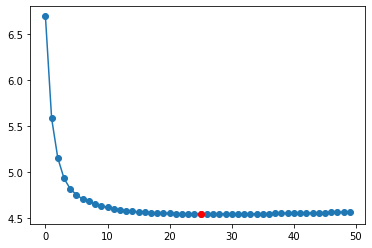

In [133]:
plt.plot(abs(clf.cv_results_['mean_test_score']), marker = 'o')
plt.plot(clf.best_index_, abs(clf.best_score_), marker = 'o', color = 'red')

Below is a plot of the root mean squared errors of the weighted KNN model. The red dot signifies which K minimizes the root mean squred error. 

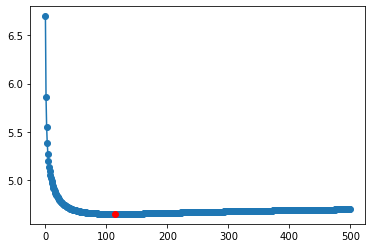

In [134]:
plt.plot(abs(clfWeighted.cv_results_['mean_test_score']), marker = 'o')
plt.plot(clfWeighted.best_index_, abs(clfWeighted.best_score_), marker = 'o', color = 'red')

Below are the RMSE's of our best weighted and non-weighted KNN models on our training set. Note that the best non-weighted model is slightly better than the best weighted model. 

In [64]:
print('The best non-weighted k is', '25', 'with a root mean squared error of', '4.541938998318994')
print('The best weighted k is', '115', 'with a root mean squared error of', '4.6503048395451145')

The best non-weighted k is 25 with a root mean squared error of 4.541938998318994
The best weighted k is 115 with a root mean squared error of 4.6503048395451145


Below are the results of the predictions on our test set using our non-weighted KNN model.

In [24]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
model1 = KNeighborsRegressor(n_neighbors = 25, weights = 'uniform')
model1fit = model1.fit(X_train, y_train)
predz = model1fit.predict(X_test)
print('The RMSE of the test set using a non-weighted KNN model with K = 25 is', mean_squared_error(y_test,predz, squared = False))
print('The MAE of the test set using a non-weighted KNN model with K = 25 is', mean_absolute_error(y_test,predz))

The RMSE of the test set using a non-weighted KNN model with K = 25 is 4.614308202484779
The MAE of the test set using a non-weighted KNN model with K = 25 is 3.1304893055962495


Below are the results of our weighted KNN model on our test set. Note that the best non-weighted model is slightly better than the best weighted model.

In [25]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
model2 = KNeighborsRegressor(n_neighbors = 115, weights = 'distance')
model2fit = model2.fit(X_train, y_train)
predz = model2fit.predict(X_test)
print('The RMSE of the test set using a weighted KNN model with K = 115 is', mean_squared_error(y_test,predz, squared = False))
print('The MAE of the test set using a weighted KNN model with K = 115 is', mean_absolute_error(y_test,predz))

The RMSE of the test set using a weighted KNN model with K = 115 is 4.72525055874405
The MAE of the test set using a weighted KNN model with K = 115 is 3.19833053952896


Here, we read in the hold out set. We must preprocess the holdout set in the same way we did the training set. 

In [26]:
holdOut = pd.read_csv('/home/drew/School/Semester4/ML1/NewYorkCityCrimes2015/Data/Lab2_Daily_Crime_Volume_Data/Hold_Out_Set.csv', parse_dates = ['CMPLNT_FR_DT'])


Here, we turn day of week into a numeric variable.

In [27]:
holdOut['DayOfWeek'] = holdOut['CMPLNT_FR_DT'].dt.dayofweek

Here, we turn month into a numeric variable.

In [28]:
holdOut['Month_No'] = holdOut['CMPLNT_FR_DT'].dt.month

Here, we turn population from a string to a numeric variable.

In [29]:
holdOut['Population'] = pd.to_numeric(holdOut['Population'].str.replace(',','', regex = False))

Here, we remove all the non-numeric variables and create dummy variables for the Daytime variable. 

In [30]:
holdOutKNNdf = holdOut.drop(['Holiday', 'Event', 'Day_Name', 'Month', 'BORO_NM', 'PC_INCOME', 'Hm_Sls_Price_Range', 'Season', 'CMPLNT_FR_DT'], axis = 1)
holdOutKNNdf = pd.get_dummies(holdOutKNNdf)

Here, we double check that all our variables are numeric. They are, so we may proceed.

In [32]:
holdOutKNNdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18962 entries, 0 to 18961
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Day                    18962 non-null  float64
 1   Year                   18962 non-null  float64
 2   GeoCell                18962 non-null  float64
 3   PRCP                   18962 non-null  float64
 4   SNOW                   18962 non-null  float64
 5   TMIN                   18962 non-null  int64  
 6   TMAX                   18962 non-null  int64  
 7   Population             18962 non-null  int64  
 8   is_Holiday             18962 non-null  int64  
 9   is_Event               18962 non-null  int64  
 10  count_cmplnt           18962 non-null  int64  
 11  DayOfWeek              18962 non-null  int64  
 12  Month_No               18962 non-null  int64  
 13  Daytime_Day            18962 non-null  uint8  
 14  Daytime_Early Morning  18962 non-null  uint8  
 15  Da

Here we separate our response variable from our explanatory variables.

In [33]:
from sklearn.model_selection import train_test_split
holdoutX_unscaled = holdOutKNNdf.drop(['count_cmplnt'], axis = 1)
holdouty = holdOutKNNdf['count_cmplnt']


Here, we scale our explanatory variables using the scaler from our training data set. 

In [34]:
from sklearn.preprocessing import StandardScaler
holdoutX = scaleFit.transform(holdoutX_unscaled)


Here, we predict the holdout data using the non-weighted KNN model. 

In [36]:
predz = model1fit.predict(holdoutX)
print('The RMSE of the holdout set using a non-weighted KNN model with K = 25 is', mean_squared_error(holdouty,predz, squared = False))
print('The MAE of the holdout set using a non-weighted KNN model with K = 25 is', mean_absolute_error(holdouty,predz))

The RMSE of the holdout set using a non-weighted KNN model with K = 25 is 4.505020893131099
The MAE of the holdout set using a non-weighted KNN model with K = 25 is 3.0963400485180888


Here, we predict the holdout data using the weighted KNN model.

In [38]:
predz = model2fit.predict(holdoutX)
print('The RMSE of the holdout set using a weighted KNN model with K = 115 is', mean_squared_error(holdouty,predz, squared = False))
print('The MAE of the holdout set using a weighted KNN model with K = 115 is', mean_absolute_error(holdouty,predz))

The RMSE of the holdout set using a weighted KNN model with K = 115 is 4.610143714899564
The MAE of the holdout set using a weighted KNN model with K = 115 is 3.1598076914580737


Below are the results of our KNN model building. Note that the Non-Weighted KNN model performed slightly better than our weighted KNN model in every single metric, so we will move forward with the non-weighted model in our comparison to our other two regression models. 

|Model|K|Training RMSE|Test Set RMSE|Holdout Set RMSE|Test Set MAE|Holdout Set MAE|
|:--|:-:|:-:|:-:|:-:|:-:|:-:|
|Non-Weighted KNN|25|4.54|4.61|4.51|3.13|3.10|
|Weighted KNN|115|4.65|4.73|4.61|3.19|3.16|

## Modeling and Evaluation 5

|Model|Advantages|Disadvantages|
|:--|:-:|:-:|
|Model Creation|No model creation necessary. Once you figure out your optimal K, you can immediately fit your data.|Finding optimal K is time consuming and may not be the same across data sets|
|Variable Importance||There is no way to find variable importance directly from a KNN model.|
|Speed|Since we don't have to create a model, KNN has incredibly fast model creation.|It may take a while to fit data if you have many dimensions.|
|Accuracy||Performed the worst out of all of our regression models for this problem|
|Misc|Non-parametric|Needs an appropriate distance measure|

## Modeling and Evaluation 6

KNN doesn't lend itself to variable importances, since we regress on how close nearest data points are. Please look at the results of other analyses in order to see what variables are most important to predicting number of crimes in each geo cell at each time. 

<a href="#top">Back to Top</a>
<a id="task1Model2"></a>
## Task 1 - Regression - Model 2 - Logistic Regression

### Data Preparation Part 1

Much of the data preparation occured in the submission made for the EDA and Mini-lab.  

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [8]:
crime = pd.read_csv('C:/Users/sabri/Documents/GitHub/NewYorkCityCrimes2015/Lab2_Individual_Files/Sabrina/Training_and_Test_Set.csv') # read in the csv %%file

This version of the dataset has been amended to include exogenous variables not part of the original datset.  These items were introduced in the EDA portion of our work, but will be revisited here.


|Variable Label|Variable Type|Data Description|
| :-|:-|:-|
|CMPLNT_FR_DT|Datestamp|	Exact date of occurrence for the reported event (or starting date of occurrence, if CMPLNT_TO_DT exists)|
|Daytime|Categorical|Binned Timeframe |Data creating six groups per day ranging from early morning to late night|
|Day_Name|Categorical|Day Of Week|
|Month|Categorical|Month of Year|
|Day|Categorical|Day number of the month|
|Year|Categorical|Year of occurance (2014 or 2015)|
|Season|Categorical|Seasonal Category created from Month Name|
|GeoCell|Categorical|Conversion of Latitude/Longitude into 100 cells in a 10x10 grid of NYC|
|Boro_NM|Categorical|One of 5 Borough Names|
|PRCP|Continuous|Precipitation measured on that date (in inches)|
|SNOW|Continuous|Snow measured on that date (in inches)|
|TMIN|Continuous|Minimum temperature measured on that date (Farenheit)|
|TMAX|Continuous|Maximum temperature measured on that date (Farenheit)|
|Population|Continuous|Borough Population as defined inthe 2010 Census|
|PC_INCOME|Continuous|Borough Population Average Income|
|HM_Sls_Price_Range|Categorical|Binned Housing price ranges|
|Holiday|Categorical|Named Holiday|
|Event|Categorical|City Event that Occured|
|is_Holiday|Boolean|Y/N description of if Holiday occured|
|is_Event|Boolean|Y/N description of if Event occured|
|count_cmplnt|Continous|TARGET VARIABLE FOR PREDICTION|

In [9]:
crime.head()

CMPLNT_FR_DT     Daytime   Day_Name     Month  Day  Year  Season  GeoCell  \
0   11/26/2014     Morning  Wednesday  November   26  2014    Fall       66   
1    12/1/2014  Late Night     Monday  December    1  2014  Winter       60   
2   11/10/2015     Morning    Tuesday  November   10  2015    Fall       15   
3     2/4/2014     Morning    Tuesday  February    4  2014  Winter       48   
4    8/25/2015  Late Night    Tuesday    August   25  2015  Summer       35   

    BORO_NM  PRCP  ...  TMIN  TMAX  Population  PC_INCOME  Hm_Sls_Price_Range  \
0    QUEENS  1.24  ...    34    51     2250002      40997              Medium   
1    QUEENS  0.09  ...    42    65     2250002      40997              Medium   
2  BROOKLYN  0.26  ...    51    57     2552911      43915                High   
3    QUEENS  0.00  ...    22    35     2250002      40997              Medium   
4  BROOKLYN  0.00  ...    73    90     2552911      43915                High   

  Holiday Event is_Holiday  is_Event  count_cmplnt  
0     NaN   NaN          0         0             1  
1     NaN   NaN          0         0             1  
2     NaN   NaN          0         0             2  
3     NaN   NaN          0         0             3  
4     NaN   NaN          0         0             1  

[5 rows x 21 columns]

In [10]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170650 entries, 0 to 170649
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   CMPLNT_FR_DT        170650 non-null  object 
 1   Daytime             170650 non-null  object 
 2   Day_Name            170650 non-null  object 
 3   Month               170650 non-null  object 
 4   Day                 170650 non-null  int64  
 5   Year                170650 non-null  int64  
 6   Season              170650 non-null  object 
 7   GeoCell             170650 non-null  int64  
 8   BORO_NM             170650 non-null  object 
 9   PRCP                170650 non-null  float64
 10  SNOW                170650 non-null  float64
 11  TMIN                170650 non-null  int64  
 12  TMAX                170650 non-null  int64  
 13  Population          170650 non-null  int64  
 14  PC_INCOME           170650 non-null  int64  
 15  Hm_Sls_Price_Range  170650 non-nul

As noted above, there are categorical variables that need to be transformed into a format that can be used in linear regression.  For that, we will use one-hot encoding.

In [11]:
# perform one-hot encoding of the categorical data 
tmp_df = pd.get_dummies(crime.BORO_NM,prefix='BORO_NM')
crime = pd.concat((crime,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(crime.Day_Name,prefix='Day_Name')
crime = pd.concat((crime,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(crime.Month,prefix='Month')
crime = pd.concat((crime,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(crime.Season,prefix='Season')
crime = pd.concat((crime,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(crime.Daytime,prefix='Daytime')
crime = pd.concat((crime,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(crime.Daytime,prefix='Hm_Sls_Price_Range')
crime = pd.concat((crime,tmp_df),axis=1) # add back into the dataframe

In [13]:
#Now we drop the original variables
if 'BORO_NM' in crime:    
    del crime['BORO_NM'] # get rid of the original category as it is now one-hot encoded
if 'Day_Name' in crime:    
    del crime['Day_Name'] # get rid of the original category as it is now one-hot encoded
if 'Month' in crime:    
    del crime['Month'] # get rid of the original category as it is now one-hot encoded
if 'Season' in crime:    
    del crime['Season'] # get rid of the original category as it is now one-hot encoded
if 'Daytime' in crime:    
    del crime['Daytime'] # get rid of the original category as it is now one-hot encoded
if 'Hm_Sls_Price_Range' in crime:    
    del crime['Hm_Sls_Price_Range'] # get rid of the original category as it is now one-hot encoded

In [14]:
#binary Y/N converted to Is Holiday or Is Event.  Can drop originals
if 'Holiday' in crime:    
    del crime['Holiday']
if 'Event' in crime:    
    del crime['Event']

### Data Preparation Part 2

In [15]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170650 entries, 0 to 170649
Data columns (total 53 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   CMPLNT_FR_DT                      170650 non-null  object 
 1   Day                               170650 non-null  int64  
 2   Year                              170650 non-null  int64  
 3   GeoCell                           170650 non-null  int64  
 4   PRCP                              170650 non-null  float64
 5   SNOW                              170650 non-null  float64
 6   TMIN                              170650 non-null  int64  
 7   TMAX                              170650 non-null  int64  
 8   Population                        170650 non-null  int64  
 9   PC_INCOME                         170650 non-null  int64  
 10  is_Holiday                        170650 non-null  int64  
 11  is_Event                          170650 non-null  i

### Modeling and Evaluation 1

For Linear Regression, we are using Mean Absolute Error to compare the models.  We feel this is the best measure by which to assert model efficacy because we are predicting a continuous variable.  There is no logical penalty for being above or below the target response, so we feel we can weight them equally.

### Modeling and Evaluation 2

In [16]:
from sklearn.model_selection import ShuffleSplit

if 'count_cmplnt' in crime:
    y = crime['count_cmplnt'] # get the labels we want
    del crime['count_cmplnt'] # get rid of the class label
    X = crime.values # use everything else to predict!
    
X = crime.drop('CMPLNT_FR_DT', axis=1) #dropping this because I have day, month and year as columns

In [17]:
#check datatypes for conversions needed
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170650 entries, 0 to 170649
Data columns (total 51 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Day                               170650 non-null  int64  
 1   Year                              170650 non-null  int64  
 2   GeoCell                           170650 non-null  int64  
 3   PRCP                              170650 non-null  float64
 4   SNOW                              170650 non-null  float64
 5   TMIN                              170650 non-null  int64  
 6   TMAX                              170650 non-null  int64  
 7   Population                        170650 non-null  int64  
 8   PC_INCOME                         170650 non-null  int64  
 9   is_Holiday                        170650 non-null  int64  
 10  is_Event                          170650 non-null  int64  
 11  BORO_NM_BRONX                     170650 non-null  u

In [18]:
y.describe()

count    170650.000000
mean          4.714122
std           5.140051
min           1.000000
25%           1.000000
50%           3.000000
75%           6.000000
max         132.000000
Name: count_cmplnt, dtype: float64

In [19]:
#Divide data into test and training splits
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.10, random_state=0)

### Modeling and Evaluation 3

In [21]:
#Use mean absolute error (MAE) to score the regression models created 
#(the scale of MAE is identical to the response variable)
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error

In [22]:
#Use mean absolute error (MAE) to score the regression models created 
#(the scale of MAE is identical to the response variable)
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error

#Function for Root mean squared error
#https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

#Function for Mean Absolute Percentage Error (MAPE) - Untested
#Adapted from - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python
def mape(y_actual, y_predicted): 
    mask = y_actual != 0
    return (np.fabs(y_actual - y_predicted)/y_actual)[mask].mean() * 100

#Create scorers for rmse and mape functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)
mape_scorer = make_scorer(score_func=mape, greater_is_better=False)

#Make scorer array to pass into cross_validate() function for producing mutiple scores for each cv fold.
errorScoring = {'MAE':  mae_scorer, 
                'RMSE': rmse_scorer,
                'MAPE': mape_scorer
               } 

In [23]:
from sklearn.model_selection import cross_validate

def EvaluateRegressionEstimator(regEstimator, X, y, cv):
    
    scores = cross_validate(regEstimator, X, y, scoring=errorScoring, cv=cv, return_train_score=True)

    #cross val score sign-flips the outputs of MAE
    # https://github.com/scikit-learn/scikit-learn/issues/2439
    scores['test_MAE'] = scores['test_MAE'] * -1
    scores['test_MAPE'] = scores['test_MAPE'] * -1
    scores['test_RMSE'] = scores['test_RMSE'] * -1

    #print mean MAE for all folds 
    maeAvg = scores['test_MAE'].mean()
    print_str = "The average MAE for all cv folds is: \t\t\t {maeAvg:.5}"
    print(print_str.format(maeAvg=maeAvg))

    #print mean test_MAPE for all folds
    scores['test_MAPE'] = scores['test_MAPE']
    mape_avg = scores['test_MAPE'].mean()
    print_str = "The average MAE percentage (MAPE) for all cv folds is: \t {mape_avg:.5}"
    print(print_str.format(mape_avg=mape_avg))

    #print mean MAE for all folds 
    RMSEavg = scores['test_RMSE'].mean()
    print_str = "The average RMSE for all cv folds is: \t\t\t {RMSEavg:.5}"
    print(print_str.format(RMSEavg=RMSEavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['MAE'] = scores['test_MAE']
    scoresResults['MAPE'] = scores['test_MAPE']
    scoresResults['RMSE'] = scores['test_RMSE']
    return scoresResults

In [24]:
#Create a Linear Regression object and perform a grid search to find the best parameters
linreg = LinearRegression()
parameters = {'normalize':(True,False), 'fit_intercept':(True,False)}

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X, y)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   12.6s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
             estimator=LinearRegression(),
             param_grid={'fit_intercept': (True, False),
                         'normalize': (True, False)},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [25]:
#Print the parameterization of the best estimator
regGridSearch.best_estimator_

LinearRegression(fit_intercept=False, normalize=True)

In [26]:
regEstimator = regGridSearch.best_estimator_

In [27]:
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateRegressionEstimator(regEstimator, X, y, cv)

The average MAE for all cv folds is: 			 3.142
The average MAE percentage (MAPE) for all cv folds is: 	 124.78
The average RMSE for all cv folds is: 			 4.5832
*********************************************************
Cross Validation Fold Mean Error Scores


MAE        MAPE      RMSE
0  3.124101  124.761171  4.529424
1  3.162885  125.349461  4.619970
2  3.090418  123.418469  4.568485
3  3.145296  125.423979  4.532882
4  3.182328  125.392895  4.661333
5  3.126304  122.497441  4.534450
6  3.145072  126.952563  4.581990
7  3.152822  123.560703  4.634324
8  3.171695  124.848679  4.653639
9  3.119182  125.609772  4.515929

### Modeling and Evaluation 4

In [28]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [38]:
crime_holdout = pd.read_csv('C:/Users/sabri/Documents/GitHub/NewYorkCityCrimes2015/Lab2_Individual_Files/Sabrina/Hold_Out_Set.csv') # read in the csv %%file
crime_holdout.head()

Daytime   Day_Name     Month  Day  Year  Season  GeoCell    BORO_NM  \
0     Evening  Wednesday  November    5  2014    Fall       16   BROOKLYN   
1       Night     Sunday  December   21  2014  Winter       36   BROOKLYN   
2     Morning     Sunday   October   11  2015    Fall       88      BRONX   
3       Night     Sunday       May   10  2015  Spring       56  MANHATTAN   
4  Late Night   Thursday  December   10  2015  Winter       59     QUEENS   

   PRCP  SNOW  TMIN  TMAX  Population  PC_INCOME Hm_Sls_Price_Range Holiday  \
0   0.0   0.0    56    64     2552911      41399               High     NaN   
1   0.0   0.0    31    36     2552911      41399               High     NaN   
2   0.0   0.0    53    69     1385108      32778                Low     NaN   
3   0.0   0.0    61    83     1585873     155779          Very High     NaN   
4   0.0   0.0    51    60     2250002      44031             Medium     NaN   

  Event  is_Holiday  is_Event  count_cmplnt  
0   NaN           0         0             4  
1   NaN           0         0            14  
2   NaN           0         0             4  
3   NaN           0         0             1  
4   NaN           0         0             1

In [39]:
# perform one-hot encoding of the categorical data 
tmp_df = pd.get_dummies(crime_holdout.BORO_NM,prefix='BORO_NM')
crime_holdout = pd.concat((crime_holdout,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(crime_holdout.Day_Name,prefix='Day_Name')
crime_holdout = pd.concat((crime_holdout,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(crime_holdout.Month,prefix='Month')
crime_holdout = pd.concat((crime_holdout,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(crime_holdout.Season,prefix='Season')
crime_holdout = pd.concat((crime_holdout,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(crime_holdout.Daytime,prefix='Daytime')
crime_holdout = pd.concat((crime_holdout,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(crime_holdout.Daytime,prefix='Hm_Sls_Price_Range')
crime_holdout = pd.concat((crime_holdout,tmp_df),axis=1) # add back into the dataframe

In [40]:
#Now we drop the original variables
if 'BORO_NM' in crime_holdout:    
    del crime_holdout['BORO_NM'] # get rid of the original category as it is now one-hot encoded
if 'Day_Name' in crime_holdout:    
    del crime_holdout['Day_Name'] # get rid of the original category as it is now one-hot encoded
if 'Month' in crime_holdout:    
    del crime_holdout['Month'] # get rid of the original category as it is now one-hot encoded
if 'Season' in crime_holdout:    
    del crime_holdout['Season'] # get rid of the original category as it is now one-hot encoded
if 'Daytime' in crime_holdout:    
    del crime_holdout['Daytime'] # get rid of the original category as it is now one-hot encoded
if 'Hm_Sls_Price_Range' in crime_holdout:    
    del crime_holdout['Hm_Sls_Price_Range'] # get rid of the original category as it is now one-hot encoded

In [41]:
#binary Y/N converted to Is Holiday or Is Event.  Can drop originals
if 'Holiday' in crime_holdout:    
    del crime_holdout['Holiday']
if 'Event' in crime_holdout:    
    del crime_holdout['Event']

In [42]:
from sklearn.model_selection import ShuffleSplit

if 'count_cmplnt' in crime_holdout:
    y_holdout = crime_holdout['count_cmplnt'] # get the labels we want
    del crime_holdout['count_cmplnt'] # get rid of the class label
    X_holdout = crime_holdout.values # use everything else to predict!  

In [43]:
y_holdout.describe()

count    18962.000000
mean         4.728879
std          5.088475
min          1.000000
25%          1.000000
50%          3.000000
75%          6.000000
max         44.000000
Name: count_cmplnt, dtype: float64

In [44]:
y_holdout_pred = regEstimator.predict(X_holdout)

In [45]:
from sklearn.metrics import *
print('Mean Absolute Error', mean_absolute_error(y_holdout, y_holdout_pred),'crimes per period')

Mean Absolute Error 3.1117755067258623 crimes per period


<a href="#top">Back to Top</a>
<a id="task1Model3"></a>
## Task 1 - Regression - Model 3 - Random Forest Regression

**Goal:**  
We want to develop a model that will predict crime volume for different NYC Borough locations for different times of day around the year.  Therefore, we've implemented a regression model using Random Forest Regression. 

This model can be used to get an accurate idea of the volume of crime to expect and could be useful for law enforcement to know how to distribute man power throughout the city for maximum coverage on give days and times of day.

### Data Preparation Part 1

For initial model development and feature analysis, the features were reduced down to a subset that sought to avoid data leakage and maximize liklihood of importance based on whether or not the value changed daily.  We dropped features such as population, income and home sales prices as they were annual figures so didn't change on a daily basis, thus do not have discriminatory power.  

Preprocessing of the data consisted of aggregating the raw data creating the count_cmplnt field that will be used as our target variable.  The count_cmplnt field is the total volume of crimes that occurred during a given period of the day (Early Morning, Morning, Day, Afternoon, etc..)  

For this model, we dropped variables that have very little to no predictive power or were captured by other variables. These included, population, PC_Income, Hm_Sls_Price_Range and cmplnt_fr_dt as that is captured by month, day, and year.

We chose to one hot encode the categorical features and scale the continuous variables.

One Hot encoded features:
- Daytime
- Day_Name
- Month
- Season
- BORO_NM
- Holiday
- Event

Scaled features:
- PRCP
- SNOW
- TMIN
- TMAX

Features left unchanged:
- is_Holiday
- is_Event
- Day
- Year
- GeoCell

These features were used for initial model development.  In Data Preparation Part 2, we detail which are the final features selected based in Gini-Importance along with their meaning.

In [3]:
import altair as alt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

#load csv
file_path = "C:\\Users\\BGaither\\OneDrive - McAfee\\Other\\school\\SMU\\Courses\\Fall 2020\\Machine Learning I\\Lab 2\\Data\\Training_and_Test_Set.csv"
#load Data into Pandas
df_Crime = pd.read_csv(file_path)

In C:\Users\BGaither\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\BGaither\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\BGaither\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\BGaither\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\BGaither\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_c

In [4]:
df_Crime.head(5)

CMPLNT_FR_DT     Daytime   Day_Name     Month   Day    Year  Season  \
0   11/26/2014     Morning  Wednesday  November  26.0  2014.0    Fall   
1    12/1/2014  Late Night     Monday  December   1.0  2014.0  Winter   
2   11/10/2015     Morning    Tuesday  November  10.0  2015.0    Fall   
3     2/4/2014     Morning    Tuesday  February   4.0  2014.0  Winter   
4    8/25/2015  Late Night    Tuesday    August  25.0  2015.0  Summer   

   GeoCell   BORO_NM  PRCP  ...  TMIN  TMAX  Population PC_INCOME  \
0     66.0    QUEENS  1.24  ...    34    51   2,250,002     40997   
1     60.0    QUEENS  0.09  ...    42    65   2,250,002     40997   
2     15.0  BROOKLYN  0.26  ...    51    57   2,552,911     43915   
3     48.0    QUEENS  0.00  ...    22    35   2,250,002     40997   
4     35.0  BROOKLYN  0.00  ...    73    90   2,552,911     43915   

   Hm_Sls_Price_Range Holiday Event is_Holiday  is_Event  count_cmplnt  
0              Medium     NaN   NaN          0         0             1  
1              Medium     NaN   NaN          0         0             1  
2                High     NaN   NaN          0         0             2  
3              Medium     NaN   NaN          0         0             3  
4                High     NaN   NaN          0         0             1  

[5 rows x 21 columns]

In [5]:
df_Crime.shape

(170650, 21)

In [6]:
#let's check for NaN values in the dataset
len(df_Crime) - df_Crime.count()

CMPLNT_FR_DT               0
Daytime                    0
Day_Name                   0
Month                      0
Day                        0
Year                       0
Season                     0
GeoCell                    0
BORO_NM                    0
PRCP                       0
SNOW                       0
TMIN                       0
TMAX                       0
Population                 0
PC_INCOME                  0
Hm_Sls_Price_Range         0
Holiday               166062
Event                 144780
is_Holiday                 0
is_Event                   0
count_cmplnt               0
dtype: int64

In [7]:
#since the only NANs are in Holiday and Event, we'll replace those NaNs with 'None'
df_Crime = df_Crime.fillna('None')

In [8]:
#let's make sure we've taken care of all the NaNs
len(df_Crime) - df_Crime.count()

CMPLNT_FR_DT          0
Daytime               0
Day_Name              0
Month                 0
Day                   0
Year                  0
Season                0
GeoCell               0
BORO_NM               0
PRCP                  0
SNOW                  0
TMIN                  0
TMAX                  0
Population            0
PC_INCOME             0
Hm_Sls_Price_Range    0
Holiday               0
Event                 0
is_Holiday            0
is_Event              0
count_cmplnt          0
dtype: int64

In [9]:
#drop population, PC_Income and Hm_Sls_Price_Range as they do not vary daily
#drop cmplnt_fr_dt as that is captured by month, day, and year
df_Crime = df_Crime[['Daytime','Day_Name','Month','Day','Year','Season','GeoCell','BORO_NM','PRCP','SNOW','TMIN','TMAX','Holiday','Event','is_Holiday','is_Event','count_cmplnt']]

In [10]:
X = df_Crime[['Daytime','Day_Name','Month','Day','Year','Season','GeoCell','BORO_NM','PRCP','SNOW','TMIN','TMAX','Holiday','Event','is_Holiday','is_Event']]
y = df_Crime[['count_cmplnt']]

### Data Preparation Part 2

After fitting a preliminary Random Forest Regression model, we've identified the top performing features using the Gini-importances with a threshold of >.004 which selects 22 features to feed into the model.

**Inputs to the model are:**

The following features are scaled:
- PRCP: amount of rainfall for the day
- TMIN: minimum temp for the day
- TMAX: maximum temp for the day

The following features are one hot encoded:
- Daytime:  time period of the day (Early Morning, Morning, Day, Afternoon, Evening, etc...)
- Month: the month for which you would like to predict crime volume
- Day_Name:  Day of the week (Monday, Tuesday, Wednesday, ect...)
- BORO_NM: Name of the borough you would like to predict crime volume

The following features are left unchanged:
- Day: the day of the month in numerical format
- Year: the year in numerical format YYYY
- GeoCell: We would need to perform feature transformation taking inputs x_coordinate and y_coordinate to calculate the GeoCell and then pass GeoCell value to the model.  This allows us to use geolocation details in a more abstract way to avoid overfitting to an exact location.

In [11]:
#one hot encode the categorical features
from sklearn.preprocessing import StandardScaler, OneHotEncoder

columns_to_encode = ['Daytime','Day_Name','Month','Season','BORO_NM','Holiday','Event']
columns_no_change = ['is_Holiday','is_Event','Day','Year','GeoCell','PRCP','SNOW','TMIN','TMAX']

df_existing = X[columns_no_change]
existing_cols = df_existing.to_numpy()

#encoder 
ohe = OneHotEncoder(sparse=False)

#ohe separate columns
encoded_columns = ohe.fit_transform(X[columns_to_encode])

#concatenate processed columns back together for X
X = np.concatenate([encoded_columns,existing_cols],axis=1)

#get the column names back to the dataframe
df1 = pd.DataFrame(X)
feature_names = ohe.get_feature_names().tolist()
col_names = feature_names+columns_no_change
df1.columns = col_names
X = df1

In [12]:
#scale specific columns
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#go ahead and split the data so we can scale data separately on training and then on test so we don't have leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

columns_to_scale = ['PRCP','SNOW','TMIN','TMAX']
#get a list of all columns without the columns to scale above
lstCols = X.columns.values.tolist()
lstCols.remove('PRCP')
lstCols.remove('SNOW')
lstCols.remove('TMIN')
lstCols.remove('TMAX')
columns_no_change = lstCols

df_existing = X_train[columns_no_change]
existing_cols = df_existing.to_numpy()

#scaler
scaler = StandardScaler()

#scale and encode separate columns
scaled_columns = scaler.fit_transform(X_train[columns_to_scale])

#concatenate processed columns back together for X_train
X_train_np = np.concatenate([scaled_columns,existing_cols],axis=1)

df_existing = X_test[columns_no_change]
existing_cols = df_existing.to_numpy()

#separately scale X_test
scaled_columns = scaler.transform(X_test[columns_to_scale]) #use the fit scaler object from X_train to scale X_test

X_test_np = np.concatenate([scaled_columns,existing_cols],axis=1)

In [13]:
#convert the numpy array back to a pandas dataframe for X_train
df1 = pd.DataFrame(X_train_np)
#get the column names back to the dataframe
col_names = columns_to_scale+columns_no_change
df1.columns = col_names
X_train = df1

#convert the numpy array back to a pandas dataframe for X_test
df1 = pd.DataFrame(X_test_np)
#get the column names back to the dataframe
col_names = columns_to_scale+columns_no_change
df1.columns = col_names
X_test = df1

In [14]:
#Let's take a look at the count_cmplnt target variable and get an idea of the distribution of crime volumes
#we can see that 75% of the data is between 1 and 6 crimes with some outliers of up to 132 crimes per period
y_train[['count_cmplnt']].describe()

count_cmplnt
count  136520.000000
mean        4.711742
std         5.144352
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max       132.000000

In [15]:
#let's perform a 5 fold cross validation using a baseline Random Forest Regression model and evaluate the results
#we can see that the five results are very close to one another so our model is quite stable
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#create regressor object
reg = RandomForestRegressor(n_estimators = 50, random_state = 0)

#5 fold cross validation
%time cv_results = cross_val_score(reg, X_train, y_train.values.ravel(), cv=5, scoring='neg_mean_absolute_error')
print('Cross Validation Results: {}'.format(cv_results))

Wall time: 3min 53s
Cross Validation Results: [-1.65603575 -1.64081234 -1.63430779 -1.637207   -1.6277864 ]


In [16]:
#Next, we'll fit a base Random Forest Regression model again so that we can grab the most important features
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(n_estimators = 50, random_state = 0)
%time reg.fit(X_train,y_train.values.ravel())
y_pred = reg.predict(X_test)

Wall time: 1min


### Modeling and Evaluation 1

To assess our regression models, we will be comparing the Root Mean Squared Error (RMSE) and Mean Absolute Error.  The best model will have the smallest resulting value from these metrics as it is indicative of the amount of error in our model.

RMSE is a measure of the goodness of fit of the model.  RMSE gives a penalty to large prediction errors by squaring it.
MAE is taking the sum of the absolute error.  MAE is a more direct representation of the sum of error terms.


<AxesSubplot:>

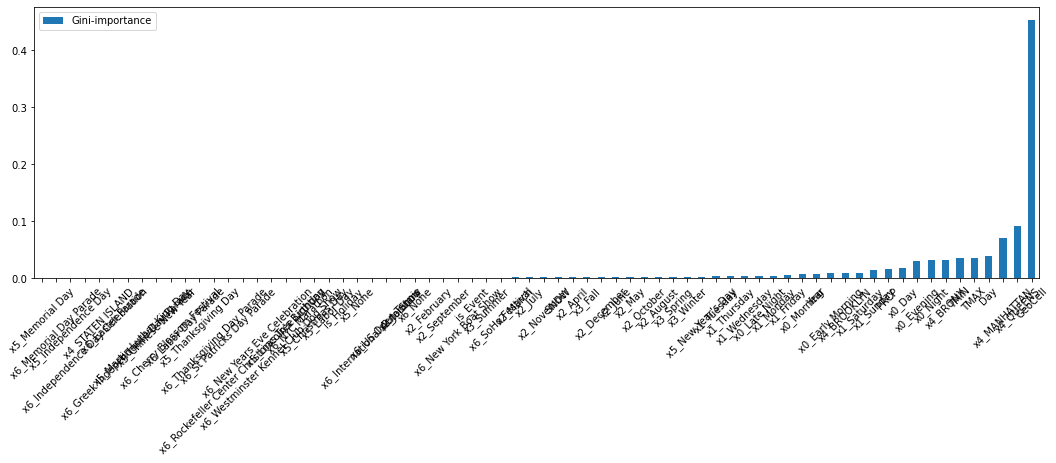

In [17]:
#get feature importance
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_test.columns, reg.feature_importances_):
    feats[feature] = importance #add the name/value pair 
    #print('{}, Score: %.5f'.format(feature) %(importance))

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(figsize=(18,5),kind='bar', rot=45)

In [18]:
#next, we'll grab the most important features using the threshold of gini-importance > .004
df_top_features = importances[importances['Gini-importance']>.004]
df_top_features['feature'] = df_top_features.index
top_features = df_top_features['feature'].tolist()

df_top_features.sort_values(by='Gini-importance',ascending=False)

C:\Users\BGaither\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Gini-importance           feature
GeoCell                  0.453479           GeoCell
x4_QUEENS                0.092685         x4_QUEENS
x4_MANHATTAN             0.070824      x4_MANHATTAN
Day                      0.039940               Day
TMAX                     0.036671              TMAX
TMIN                     0.035702              TMIN
x4_BRONX                 0.033021          x4_BRONX
x0_Night                 0.032610          x0_Night
x0_Evening               0.030263        x0_Evening
x0_Day                   0.019059            x0_Day
PRCP                     0.016485              PRCP
x1_Sunday                0.014150         x1_Sunday
x1_Saturday              0.010036       x1_Saturday
x4_BROOKLYN              0.008953       x4_BROOKLYN
x0_Early Morning         0.008850  x0_Early Morning
Year                     0.008067              Year
x0_Morning               0.008059        x0_Morning
x1_Friday                0.006750         x1_Friday
x1_Monday                0.004929         x1_Monday
x0_Late Night            0.004314     x0_Late Night
x1_Wednesday             0.004311      x1_Wednesday
x1_Thursday              0.004171       x1_Thursday

In [19]:
#columns to keep based on feature importance
X_train=X_train[top_features]

X_test = X_test[top_features]

### Modeling and Evaluation 2

First off, we randomly selected 10% of the total dataset as a holdout set that we'll use to compare all models against for the regression task. This will ensure we're comparing models against the same dataset. 

Then, from the remaining 90% of the data, we split the data into an 80/20 training/test set.

This approach is appropriate as we want the model to learn how to predict crime volumes based on given independent variables.  The split was actually performed above in Data Perparation Part 2 of this section.

### Modeling and Evaluation 3

Now we will implement the Random Forest Regression model utilizing the data prepared above.

In [ ]:
#First, we'll perform a grid search to identify the optimal hyperparameters for the model
#Set up the parameters for grid search
parameters = {'n_estimators' : (30,50,70,90),
              'criterion' : ('mse','mae'),
              'max_depth' : (5,7,9,10),
              'max_features' : ('auto','sqrt'),
              'min_samples_split' : (2,4,6)
             }

In [ ]:
#since grid search is taking a long time with full training data, we'll subsample 
y_train.reset_index(drop=True,inplace=True)
df = pd.concat([X_train,y_train], axis=1)
len(df) - df.count()

In [ ]:
#take a randome 50% sample of the data for grid search
df_ds = df.sample(frac=.5,replace=True,random_state=1)
lstCols = df_ds.columns.values.tolist()
lstCols.remove('count_cmplnt')
X_ds_train = df_ds[lstCols]
y_ds_train = df_ds[['count_cmplnt']]

Since the grid search put a lot of load on my local machine, I used an AWS Sagemaker instance with an EC2 instance with a lot of compute to perform the Grid Search.  Therefore, the code to perform the grid search is below but I've included the results of the Grid Search in Markdown below to avoid running the code again locally.

In [ ]:
# reg_grid = GridSearchCV(RandomForestRegressor(n_jobs=-1,oob_score=False),param_grid=parameters,cv=3,verbose=True)
# %time reg_grid_model = reg_grid.fit(X_ds_train,y_ds_train.values.ravel())

In [ ]:
# reg_grid_model.best_estimator_

#### Results of the Grid Search


Time taken:  4h 30min using SageMaker ml.c5.9xlarge

<b> Best Estimator: </b>

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
                      
                      
<b> Best Score (MAE)</b>

0.7295567982206977

#### Implement the Best Model from Grid Search

In [20]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(bootstrap=True, 
                            ccp_alpha=0.0, 
                            criterion='mae',
                            max_depth=10, 
                            max_features='auto', 
                            max_leaf_nodes=None,
                            max_samples=None, 
                            min_impurity_decrease=0.0,
                            min_impurity_split=None, 
                            min_samples_leaf=1,
                            min_samples_split=2, 
                            min_weight_fraction_leaf=0.0,
                            n_estimators=50, 
                            n_jobs=-1, 
                            oob_score=False,
                            random_state=None, 
                            verbose=0, 
                            warm_start=False)
%time reg.fit(X_train,y_train.values.ravel())

Wall time: 1h 1min 10s


RandomForestRegressor(criterion='mae', max_depth=10, n_estimators=50, n_jobs=-1)

In [21]:
y_pred = reg.predict(X_test)

### Modeling and Evaluation 4

#### Analyze the model against the Test Set

Analyzing the results of the final Random Forest Regression model.

Below, we can see the model metrics MAE, RMSE and the R<sup>2</sup> against the test set

In [22]:
from sklearn.metrics import *

#print out the mean absolute error (mae)
print('Mean Absolute Error:', mean_absolute_error(y_test,y_pred),'crimes per period')
print('Root Mean Squared Error:', mean_squared_error(y_test,y_pred, squared=False),'crimes per period')
print('r2:',r2_score(y_test,y_pred))

Mean Absolute Error: 1.7450969821271607 crimes per period
Root Mean Squared Error: 2.7592213367177587 crimes per period
r2: 0.7098933109052783


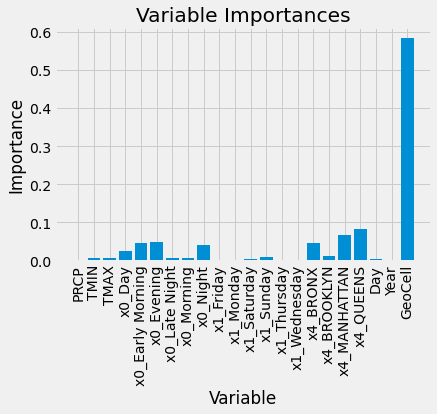

In [23]:
importances = list(reg.feature_importances_)
feature_list = X_train.columns.values.tolist()

%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [24]:
#let's combine the data so that we can plot the predicted agains the actuals for a subset of the data to visually inspect
y_test.reset_index(drop=True,inplace=True)
df_testWithPreds = pd.concat([X_test,y_test],axis=1)
df_testWithPreds["prediction"] = reg.predict(X_test)
df_testWithPreds['PredLessActual'] = df_testWithPreds['prediction']-df_testWithPreds['count_cmplnt']

Text(0.5, 1.0, 'Actual and Predicted Values against Test Set')

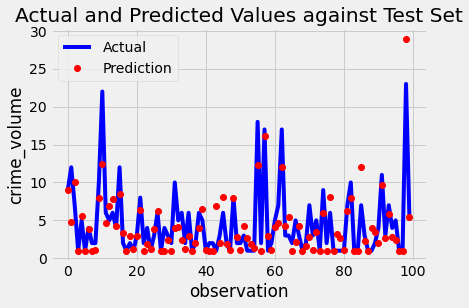

In [25]:
plt.plot(df_testWithPreds['count_cmplnt'].head(100),'b-',label='Actual')
plt.plot(df_testWithPreds['prediction'].head(100),'ro',label='Prediction')
plt.legend()
plt.xlabel('observation'); plt.ylabel('crime_volume'); plt.title('Actual and Predicted Values against Test Set')

{'whiskers': [<matplotlib.lines.Line2D at 0x26e8aea4788>,
 'caps': [<matplotlib.lines.Line2D at 0x26e8aed2ec8>,
 'boxes': [<matplotlib.lines.Line2D at 0x26e8aecf908>],
 'medians': [<matplotlib.lines.Line2D at 0x26e8aed2fc8>],
 'fliers': [<matplotlib.lines.Line2D at 0x26e8aed8f08>],
 'means': []}

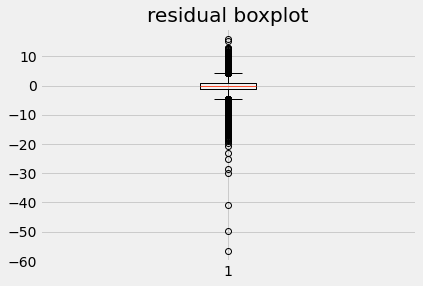

In [26]:
fig1, ax1 = plt.subplots()
ax1.set_title('residual boxplot')
ax1.boxplot(df_testWithPreds['PredLessActual'])

#### Run model against holdout data

We have created a holdout set so that we can compare various regression models against the same dataset.  Below, we'll load the data and run inference using the trained model. 

We'll first need to perform the same preprocessing to the holdout set that was done for the train and test set above.

In [27]:
#load csv
file_path = "C:\\Users\\BGaither\\OneDrive - McAfee\\Other\\school\\SMU\\Courses\\Fall 2020\\Machine Learning I\\Lab 2\\Data\\Hold_Out_Set.csv"
#load Data into Pandas
df_Holdout = pd.read_csv(file_path)

In [28]:
#since the only NANs are in Holiday and Event, we'll replace those NaNs with 'None' as we did in the train and test set
df_Holdout = df_Holdout.fillna('None')

In [29]:
#check for NaNs again to verify we've taken care of them all
len(df_Holdout) - df_Holdout.count()

CMPLNT_FR_DT          0
Daytime               0
Day_Name              0
Month                 0
Day                   0
Year                  0
Season                0
GeoCell               0
BORO_NM               0
PRCP                  0
SNOW                  0
TMIN                  0
TMAX                  0
Population            0
PC_INCOME             0
Hm_Sls_Price_Range    0
Holiday               0
Event                 0
is_Holiday            0
is_Event              0
count_cmplnt          0
dtype: int64

In [30]:
#grab the candidate variables we want to preprocess by one hot encoding and scaling as we did with the train and test sets
X_holdout = df_Holdout[['Daytime','Day_Name','Month','Day','Year','Season','GeoCell','BORO_NM','PRCP','SNOW','TMIN','TMAX','Holiday','Event','is_Holiday','is_Event']]
y_holdout = df_Holdout[['count_cmplnt']]

In [31]:
#one hot encode the categorical features
from sklearn.preprocessing import StandardScaler, OneHotEncoder

columns_to_encode = ['Daytime','Day_Name','Month','Season','BORO_NM','Holiday','Event']
columns_no_change = ['is_Holiday','is_Event','Day','Year','GeoCell','PRCP','SNOW','TMIN','TMAX']

df_existing = X_holdout[columns_no_change]
existing_cols = df_existing.to_numpy()

#encoder 
ohe = OneHotEncoder(sparse=False)

#ohe separate columns
encoded_columns = ohe.fit_transform(X_holdout[columns_to_encode])

#concatenate processed columns back together for X
X_holdout = np.concatenate([encoded_columns,existing_cols],axis=1)

#get the column names back to the dataframe
df1 = pd.DataFrame(X_holdout)
feature_names = ohe.get_feature_names().tolist()
col_names = feature_names+columns_no_change
df1.columns = col_names
X_holdout = df1

In [32]:
#scale specific columns
from sklearn.preprocessing import StandardScaler, OneHotEncoder

columns_to_scale = ['PRCP','SNOW','TMIN','TMAX']
#get a list of all columns without the columns to scale above
lstCols = X_holdout.columns.values.tolist()
lstCols.remove('PRCP')
lstCols.remove('SNOW')
lstCols.remove('TMIN')
lstCols.remove('TMAX')
columns_no_change = lstCols

df_existing = X_holdout[columns_no_change]
existing_cols = df_existing.to_numpy()

#separately scale X_holdout
scaled_columns = scaler.transform(X_holdout[columns_to_scale]) #use the fit scaler object from X_train to scale X_holdout

X_holdout_np = np.concatenate([scaled_columns,existing_cols],axis=1)

In [33]:
#convert the numpy array back to a pandas dataframe for X_holdout
df1 = pd.DataFrame(X_holdout_np)
#get the column names back to the dataframe
col_names = columns_to_scale+columns_no_change
df1.columns = col_names
X_holdout = df1

In [34]:
#get our x and y variables set to the appropriate columns
y_holdout = df_Holdout[['count_cmplnt']]
X_holdout = X_holdout[top_features]

In [35]:
#verify our columns in the x are as we expect
X_holdout.columns

Index(['PRCP', 'TMIN', 'TMAX', 'x0_Day', 'x0_Early Morning', 'x0_Evening',
       'x0_Late Night', 'x0_Morning', 'x0_Night', 'x1_Friday', 'x1_Monday',
       'x1_Saturday', 'x1_Sunday', 'x1_Thursday', 'x1_Wednesday', 'x4_BRONX',
       'x4_BROOKLYN', 'x4_MANHATTAN', 'x4_QUEENS', 'Day', 'Year', 'GeoCell'],
      dtype='object')

In [36]:
#run inference against the holdout set
y_pred_holdout = reg.predict(X_holdout)

#### Analyze the model against the Holdout Set

Analyzing the results of the final Random Forest Regression model.

Below, we can see the model metrics MAE, RMSE and the R<sup>2</sup> against the holdout set

In [37]:
from sklearn.metrics import *

#print out the mean absolute error (mae)
print('Mean Absolute Error:', mean_absolute_error(y_holdout,y_pred_holdout),'crimes per period')
print('Root Mean Squared Error:', mean_squared_error(y_holdout,y_pred_holdout, squared=False),'crimes per period')
print('r2:',r2_score(y_holdout,y_pred_holdout))

Mean Absolute Error: 1.7405859086594244 crimes per period
Root Mean Squared Error: 2.715710900010807 crimes per period
r2: 0.7151510083013456


In [38]:
y_holdout.reset_index(drop=True,inplace=True)
df_holdoutWithPreds = pd.concat([X_holdout,y_holdout],axis=1)
df_holdoutWithPreds["prediction"] = reg.predict(X_holdout)
df_holdoutWithPreds['PredLessActual'] = df_holdoutWithPreds['prediction']-df_holdoutWithPreds['count_cmplnt']

Text(0.5, 1.0, 'Actual and Predicted Values against Holdout Set')

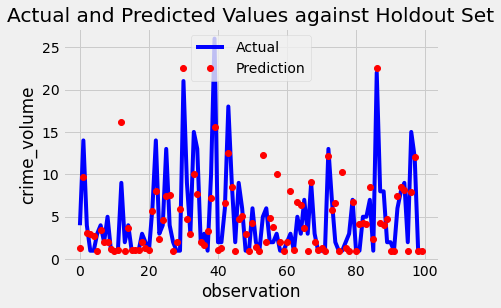

In [39]:
plt.plot(df_holdoutWithPreds['count_cmplnt'].head(100),'b-',label='Actual')
plt.plot(df_holdoutWithPreds['prediction'].head(100),'ro',label='Prediction')
plt.legend()
plt.xlabel('observation'); plt.ylabel('crime_volume'); plt.title('Actual and Predicted Values against Holdout Set')

In [40]:
df_holdoutWithPreds['PredLessActual'].describe()

count    18962.000000
mean        -0.372613
std          2.690098
min        -36.000000
25%         -1.280000
50%          0.000000
75%          0.960000
max         15.710000
Name: PredLessActual, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x26e8a4b51c8>,
 'caps': [<matplotlib.lines.Line2D at 0x26e8a4d4b08>,
 'boxes': [<matplotlib.lines.Line2D at 0x26e8a4d0d88>],
 'medians': [<matplotlib.lines.Line2D at 0x26e8a4dbfc8>],
 'fliers': [<matplotlib.lines.Line2D at 0x26e8a4dba48>],
 'means': []}

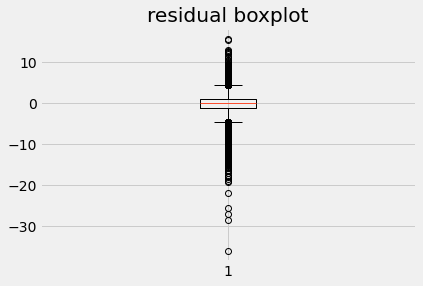

In [41]:
fig1, ax1 = plt.subplots()
ax1.set_title('residual boxplot')
ax1.boxplot(df_holdoutWithPreds['PredLessActual'])

Below are the final metrics for the Random Forest Regression including Root Mean Squared Error and Mean Absolute Error

| Model | Test Set RMSE | Holdout Set RMSE | Test Set MAE | Holdout Set MAE |
| :----------- | ----------- |----------- |----------- |----------- |
| Random Forest Regression | 2.77 | 2.72 | 1.75 | 1.74 |

<a href="#top">Back to Top</a>
<a id="task1Compare"></a>
## Task 1 - Modeling and Evaluation 5 - Comparing 3 Models

<a href="#top">Back to Top</a>
<a id="task1Attributes"></a>
## Task 1 - Modeling and Evaluation 6 - Important Attributes

<a href="#top">Back to Top</a>
<a id="task1Deployment"></a>
## Task 1 - Deployment

<a href="#top">Back to Top</a>
<a id="task2"></a>
# Task 2 - Classification

The classification task is aiming to classify a given crime as being either a Viloent or Non-Violent crime.

<a href="#top">Back to Top</a>
<a id="task2Model1"></a>
## Task 2 - Classification - Model 1 - Random Forest (Approach 1)

### Data Preparation Part 1

### Data Preparation Part 2

### Modeling and Evaluation 1

### Modeling and Evaluation 2

### Modeling and Evaluation 3

### Modeling and Evaluation 4

<a href="#top">Back to Top</a>
<a id="task2Model2"></a>
## Task 2 - Classification - Model 2 - Logistic Regression

### Data Preparation Part 1

### Data Preparation Part 2

### Modeling and Evaluation 1

### Modeling and Evaluation 2

### Modeling and Evaluation 3

### Modeling and Evaluation 4

<a href="#top">Back to Top</a>
<a id="task2Model3"></a>
## Task 2 - Classification - Model 3 - Random Forest (Approach 2)

### Data Preparation Part 1

### Data Preparation Part 2

### Modeling and Evaluation 1

### Modeling and Evaluation 2

### Modeling and Evaluation 3

### Modeling and Evaluation 4

<a href="#top">Back to Top</a>
<a id="task2Compare"></a>
## Task 2 - Modeling and Evaluation 5 - Comparing 3 Models

<a href="#top">Back to Top</a>
<a id="task2Attributes"></a>
## Task 2 -  Modeling and Evaluation 6 - Important Attributes

<a href="#top">Back to Top</a>
<a id="task2Deployment"></a>
## Task 2 - Deployment

<a href="#top">Back to Top</a>
<a id="Exceptional"></a>
# Exceptional Work